In [1]:
# Importing dependecies
import pandas as pd
import json
import requests
import prettytable
from config import api_key
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Dictionary of series ID 
category_dict = {
    'CXUFOODAWAYLB1101M': 'Food Away',
    'CXUAPPARELLB1101M': 'Apparel',
    'CXUENTRTAINLB1101M': 'Entertainment',
    'CXUCASHCONTLB1101M': 'Cash Contribution',
    'CXUALCBEVGLB1101M': 'Alcohol Beverages',
    'CXUEDUCATNLB1101M': 'Education',
    'CXUPERSCARELB1101M': 'Personal Care',
    'CXUTOBACCOLB1101M': 'Tobacco',
}

# List of series IDs
category_list = list(category_dict.keys())

In [3]:
# Load the json response for the API queries
def json_df(dictionary):
    headers = {'Content-type': 'application/json'}
    data = json.dumps({"seriesid": list(dictionary.keys()),"startyear":"2005", "endyear":"2018","registrationkey":api_key})
    p = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', data=data, headers=headers)
    json_data = json.loads(p.text)

    try:
        df = pd.DataFrame()

        # Loops through the json response to create a DataFrame
        for series in json_data['Results']['series']:
            # Create an initial DataFrame with column of Series IDs and dictionary of data
            df_initial = pd.DataFrame(series)
            series_col = df_initial['seriesID'][0]

            # Loops through the length of the initial DF to split up its second column
            for i in range(0, len(df_initial) - 1):
                df_row = pd.DataFrame(df_initial['data'][i])
                df_row['seriesID'] = series_col
                if 'code' not in str(df_row['footnotes']): 
                    df_row['footnotes'] = ''
                else:
                    df_row['footnotes'] = str(df_row['footnotes']).split("'code': '",1)[1][:1]
                df = df.append(df_row, ignore_index=True)

    except:
        json_data['status'] == 'REQUEST_NOT_PROCESSED'
        print('BLS API has given the following Response:', json_data['status'])
        print('Reason:', json_data['message'])
    return df

In [4]:
def get_total(df):
    # Initialize variables
    total = []
    dict_list = []
    i = 0
    
    # Convert the value column to float - a numeric data type will be needed to visualize the data
    df['value'] = df['value'].astype(float)
    
    series_set = set(df["seriesID"])
    for e in series_set:
        dict_list.append(e)
    
    dict_list = sorted(dict_list)
    
    # Loop through series list to create a list of the totals of each spending category
    for key in dict_list:
        # Append a value to a list to record the spending for each category
        total.append(int(df.groupby('seriesID')['value'].sum()[key]))

        # Counter
        i = i + 1
    return total

In [5]:
df_category = json_df(category_dict)

In [6]:
total = get_total(df_category)

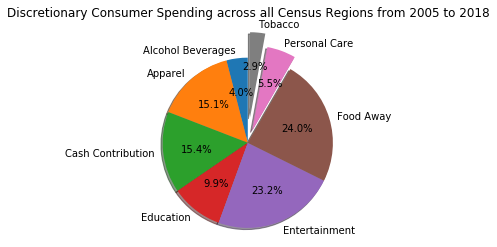

In [7]:
# Labels of the categories
labels = sorted(list(category_dict.values()))

# Explode the two smallest expenses (i.e Tobacco and Personal Care)
explode = (0, 0, 0, 0, 0, 0, .15, .3)  

# Initialize figure and axis
fig1, ax1 = plt.subplots()

# Create pie chart of the breakdown of discretionary spending
ax1.pie(total, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Discretionary Consumer Spending across all Census Regions from 2005 to 2018')
plt.xlabel('')
plt.ylabel('')
plt.show()

In [8]:
df_category = df_category.sort_values(['seriesID','year'], ascending = True).reset_index(drop=True)
df_category

,year,period,periodName,latest,value,footnotes,seriesID
0,2006,A01,Annual,NaN,497.0,,CXUALCBEVGLB1101M
1,2007,A01,Annual,NaN,457.0,,CXUALCBEVGLB1101M
2,2008,A01,Annual,NaN,444.0,,CXUALCBEVGLB1101M
3,2009,A01,Annual,NaN,435.0,,CXUALCBEVGLB1101M
4,2010,A01,Annual,NaN,412.0,,CXUALCBEVGLB1101M
...,...,...,...,...,...,...,...
99,2014,A01,Annual,NaN,319.0,,CXUTOBACCOLB1101M
100,2015,A01,Annual,NaN,349.0,,CXUTOBACCOLB1101M
101,2016,A01,Annual,NaN,337.0,,CXUTOBACCOLB1101M
102,2017,A01,Annual,NaN,332.0,,CXUTOBACCOLB1101M


In [9]:
# Get percent change over the years, grouped by series ID
df_category['pct_decimal'] = df_category.groupby(['seriesID'])['value'].pct_change()
df_category['percent_change'] = df_category['pct_decimal'].multiply(100)
df_category

,year,period,periodName,latest,value,footnotes,seriesID,pct_decimal,percent_change
0,2006,A01,Annual,NaN,497.0,,CXUALCBEVGLB1101M,NaN,NaN
1,2007,A01,Annual,NaN,457.0,,CXUALCBEVGLB1101M,-0.080483,-8.048290
2,2008,A01,Annual,NaN,444.0,,CXUALCBEVGLB1101M,-0.028446,-2.844639
3,2009,A01,Annual,NaN,435.0,,CXUALCBEVGLB1101M,-0.020270,-2.027027
4,2010,A01,Annual,NaN,412.0,,CXUALCBEVGLB1101M,-0.052874,-5.287356
...,...,...,...,...,...,...,...,...,...
99,2014,A01,Annual,NaN,319.0,,CXUTOBACCOLB1101M,-0.033333,-3.333333
100,2015,A01,Annual,NaN,349.0,,CXUTOBACCOLB1101M,0.094044,9.404389
101,2016,A01,Annual,NaN,337.0,,CXUTOBACCOLB1101M,-0.034384,-3.438395
102,2017,A01,Annual,NaN,332.0,,CXUTOBACCOLB1101M,-0.014837,-1.483680


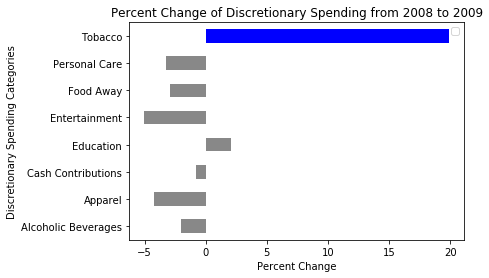

In [46]:
# Example python program to plot a horizontal bar chart
percent_chg_2009 = df_category.loc[df_category.year == '2009'][['seriesID','percent_change']]

dataFrame  = pd.DataFrame(data = percent_chg_2009)
colors = ["#888888","#888888","#888888","#888888","#888888","#888888","#888888","blue"]
dataFrame.plot.barh(x='seriesID', 
                    y='percent_change', 
                    title="Percent Change of Discretionary Spending from 2008 to 2009",
                   color=colors)

plt.yticks(np.arange(8), ("Alcoholic Beverages", 
                          "Apparel", 
                          "Cash Contributions", 
                          "Education", 
                          "Entertainment", 
                          "Food Away", 
                          "Personal Care", 
                          "Tobacco"))
plt.xlabel('Percent Change')
plt.ylabel('Discretionary Spending Categories')
plt.legend('')
plt.show(block=True)